# Using GIS To Measure Proximity to Nearest Hospital (Shortest Paths) By Toronto FSA

In [ ]:
!pip install mapclassify #helper package
!pip install osmnx
!pip install rioxarray

import geopandas as gpd # import geopandas
import osmnx as ox # import osmnx
import folium as fm # import folium
import rioxarray as rxr #import rioxarray

# packages you already familiar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import shapely.geometry
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.3 MB/s eta 0:00:00


## Health Network Fairness in Choropleth

**Healthcare-related entities**

1. {Amenity: clinic}
2. {Amenity: hospital}
3. {Amenity: doctors}

In [ ]:
warnings.filterwarnings('ignore')
place = 'toronto, ontario, canada'
tag = {'amenity': ['hospital', 'clinic']}
toronto_hospital = gpd.read_file('https://raw.githubusercontent.com/MIE223-2024/course-datasets/refs/heads/main/toronto_hospital.geojson')
toronto_hospital.head()

,name,property_type,geometry
0,Scarborough Health Network - Centenary Hospital,hospital,POINT (-79.20481 43.78025)
1,Centre For Addiction and Mental Health - Queen...,hospital,POINT (-79.41864 43.643)
2,Sunnybrook Health Sciences Centre - Bayview Ca...,hospital,POINT (-79.37479 43.7227)
3,Toronto Western Hospital,hospital,POINT (-79.40548 43.65351)
4,St. Joseph's Health Centre,hospital,POINT (-79.45006 43.6403)


In [ ]:
warnings.filterwarnings('ignore')
!wget https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lfsa000a16a_e.zip
!unzip lfsa000a16a_e.zip -d lfsa000a16a_e

toronto_FSA = gpd.read_file('lfsa000a16a_e')
# 'CFSAUID' start with m
toronto_FSA = toronto_FSA[toronto_FSA['CFSAUID'].str.startswith('M')]
toronto_FSA = toronto_FSA[['CFSAUID', 'geometry']]
toronto_FSA['property_type'] = 'FSA'
toronto_FSA.columns = ['name', 'geometry', 'property_type']
toronto_FSA.head()

--2025-03-31 01:43:38--  https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lfsa000a16a_e.zip
Resolving www12.statcan.gc.ca (www12.statcan.gc.ca)... 167.44.105.15
Connecting to www12.statcan.gc.ca (www12.statcan.gc.ca)|167.44.105.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15662579 (15M) [application/x-zip-compressed]
Saving to: ‘lfsa000a16a_e.zip’

lfsa000a16a_e.zip   100%[===================>]  14.94M  2.61MB/s    in 5.9s    

2025-03-31 01:43:44 (2.54 MB/s) - ‘lfsa000a16a_e.zip’ saved [15662579/15662579]

Archive:  lfsa000a16a_e.zip
  inflating: lfsa000a16a_e/lfsa000a16a_e.dbf  
  inflating: lfsa000a16a_e/lfsa000a16a_e.prj  
  inflating: lfsa000a16a_e/lfsa000a16a_e.shp  
  inflating: lfsa000a16a_e/lfsa000a16a_e.shx  
  inflating: lfsa000a16a_e/forward_sortation_area.html  
  inflating: lfsa000a16a_e/92-179-g2016001-eng.pdf  


,name,geometry,property_type
637,M9R,"POLYGON ((7209908.14 928259.897, 7209816.766 9...",FSA
638,M9V,"POLYGON ((7206682.694 937743.451, 7206631.563 ...",FSA
639,M9W,"POLYGON ((7210531.76 934710.503, 7210542.117 9...",FSA
701,M1P,"POLYGON ((7233594.731 942118.174, 7233584.157 ...",FSA
702,M1R,"MULTIPOLYGON (((7231166.76 939882.914, 7231356...",FSA


In [ ]:
print(toronto_hospital.crs)
print(toronto_FSA.crs)

EPSG:4326
PROJCS["PCS_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",63.390675],PARAMETER["central_meridian",-91.8666666666667],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",6200000],PARAMETER["false_northing",3000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [ ]:
#toronto_FSA.crs = toronto_hospital.crs
toronto_FSA.to_crs(epsg=4326, inplace=True)
toronto_hospital.to_crs(epsg=4326, inplace=True)
print(toronto_hospital.crs)
print(toronto_FSA.crs)

EPSG:4326
EPSG:4326


In [ ]:
toronto_FSA = toronto_FSA[['name', 'geometry', 'property_type']] # Reorder columns to match order of toronto_hospital df

gdf_all = pd.concat([toronto_FSA, toronto_hospital], axis=0, ignore_index=True)

gdf_all.head()

,name,geometry,property_type
0,M9R,"POLYGON ((-79.56131 43.67478, -79.56249 43.674...",FSA
1,M9V,"POLYGON ((-79.57759 43.76205, -79.57829 43.761...",FSA
2,M9W,"POLYGON ((-79.53885 43.72937, -79.53884 43.728...",FSA
3,M1P,"POLYGON ((-79.24704 43.75374, -79.2472 43.7536...",FSA
4,M1R,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ...",FSA


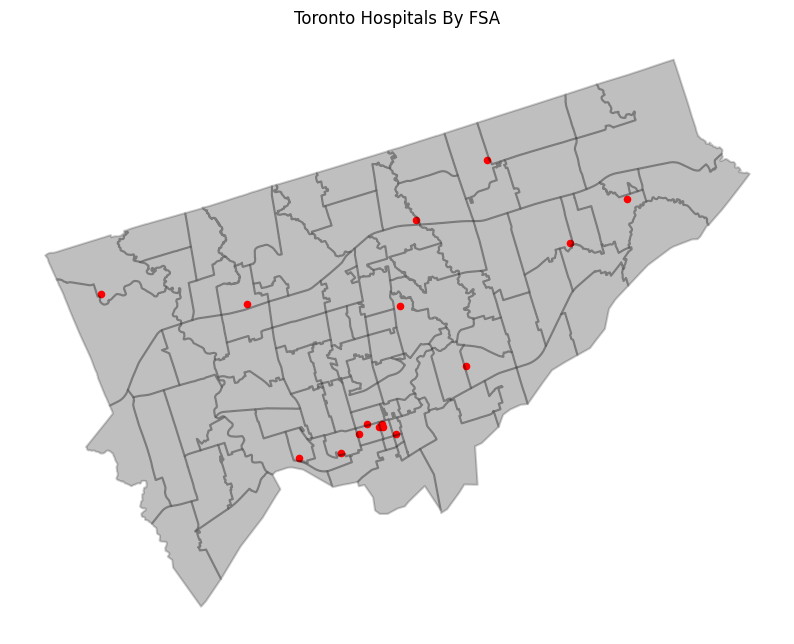

In [ ]:

#diplay the choropleth

gdf_all[gdf_all['property_type'] == 'FSA'].plot(figsize=(10, 10), legend=True, color = 'grey', alpha=0.5)
gdf_all[gdf_all['property_type'] == 'hospital'].plot(figsize=(10, 10), legend=True,
                                                           color='red', ax=plt.gca(),alpha=1, markersize=20)

gdf_all[gdf_all['property_type'] == 'FSA'].boundary.plot(figsize=(10, 10), color = 'black', ax=plt.gca(),alpha=0.2)

plt.title('Toronto Hospitals By FSA')
plt.axis('off')
plt.show()

From this map, it appears there is a high concentration of hospitals downtown, with far less in the Wesrt End (Etobicoke) and East End (Scarborough)

In [ ]:
# calculate the centroid of each row in gdf_all if it is a polygon or MultiPolygon
## Your code here ###
def get_centroid(geom):
    if geom.geom_type == 'Polygon' or geom.geom_type == 'MultiPolygon':
        return geom.centroid
    else:
        return geom


gdf_all['centroid'] = gdf_all['geometry'].apply(get_centroid)
gdf_all
##your code end here ###

,name,geometry,property_type,centroid
0,M9R,"POLYGON ((-79.56131 43.67478, -79.56249 43.674...",FSA,POINT (-79.55799 43.68778)
1,M9V,"POLYGON ((-79.57759 43.76205, -79.57829 43.761...",FSA,POINT (-79.59433 43.74274)
2,M9W,"POLYGON ((-79.53885 43.72937, -79.53884 43.728...",FSA,POINT (-79.58416 43.70983)
3,M1P,"POLYGON ((-79.24704 43.75374, -79.2472 43.7536...",FSA,POINT (-79.27 43.76213)
4,M1R,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ...",FSA,POINT (-79.29717 43.74945)
...,...,...,...,...
107,Toronto General Hospital,POINT (-79.38815 43.65865),hospital,POINT (-79.38815 43.65865)
108,Hospital for Sick Children,POINT (-79.38757 43.65727),hospital,POINT (-79.38757 43.65727)
109,Mount Sinai Hospital,POINT (-79.39032 43.65745),hospital,POINT (-79.39032 43.65745)
110,Centre For Addiction and Mental Health - Colle...,POINT (-79.39928 43.65901),hospital,POINT (-79.39928 43.65901)


In [ ]:
# calculate the distance matrix between each FSA centriod and hospital
## Your code here ###

fsa_centroid = gdf_all[gdf_all['property_type'] == 'FSA'][['name', 'centroid']]
hospital_centroid = gdf_all[gdf_all['property_type'] == 'hospital'][['name', 'centroid']]

# calculate the distance between each FSA and subway station
def get_distance_matrix(fsa_centroid, hospital_centroid) -> pd.DataFrame:
    '''
    this function is used to calculate the distance matrix between each FSA and subway station

    fsa_centroid: dataframe with the centroid of FSA
    subway_station_centroid: dataframe with  the centroid of subway station

    return: a dataframe with the distance between each FSA and subway station
    '''
    distance_matrix = np.zeros((fsa_centroid.shape[0], hospital_centroid.shape[0]))
    for i in range(fsa_centroid.shape[0]):
        for j in range(hospital_centroid.shape[0]):
            distance_matrix[i, j] = fsa_centroid.iloc[i]['centroid'].distance(hospital_centroid.iloc[j]['centroid'])
    distance_matrix = pd.DataFrame(distance_matrix, index=fsa_centroid['name'].to_list(), columns=hospital_centroid['name'])
    return distance_matrix

distance_matrix = get_distance_matrix(fsa_centroid, hospital_centroid)
distance_matrix.head()

name,Scarborough Health Network - Centenary Hospital,Centre For Addiction and Mental Health - Queen Street Site,Sunnybrook Health Sciences Centre - Bayview Campus,Toronto Western Hospital,St. Joseph's Health Centre,Michael Garron Hospital,Etobicoke General Hospital,Humber River Hospital,Scarborough Health Network - General Campus,Scarborough Health Network - Birchmount Hospital,North York General Hospital,Toronto General Hospital,Hospital for Sick Children,Mount Sinai Hospital,Centre For Addiction and Mental Health - College Street Site,St. Michael's Hospital
M9R,0.365086,0.146369,0.186494,0.156309,0.117911,0.233066,0.057618,0.078006,0.317728,0.273428,0.211529,0.172316,0.173130,0.170388,0.161292,0.183388
M9V,0.391324,0.202029,0.220449,0.208868,0.176941,0.274522,0.013983,0.107479,0.346817,0.290978,0.233110,0.222667,0.223731,0.221119,0.212260,0.234141
M9W,0.385836,0.178507,0.209764,0.187347,0.151057,0.259992,0.023838,0.096522,0.339601,0.289709,0.229242,0.202582,0.203500,0.200794,0.191738,0.213871
M1P,0.067660,0.190490,0.111969,0.173655,0.217406,0.090713,0.329641,0.222007,0.022906,0.055718,0.092980,0.157066,0.157537,0.159487,0.165377,0.152953
M1R,0.097361,0.161511,0.082105,0.144695,0.187853,0.065660,0.301504,0.193196,0.049884,0.053526,0.068432,0.128541,0.129104,0.130923,0.136407,0.125230


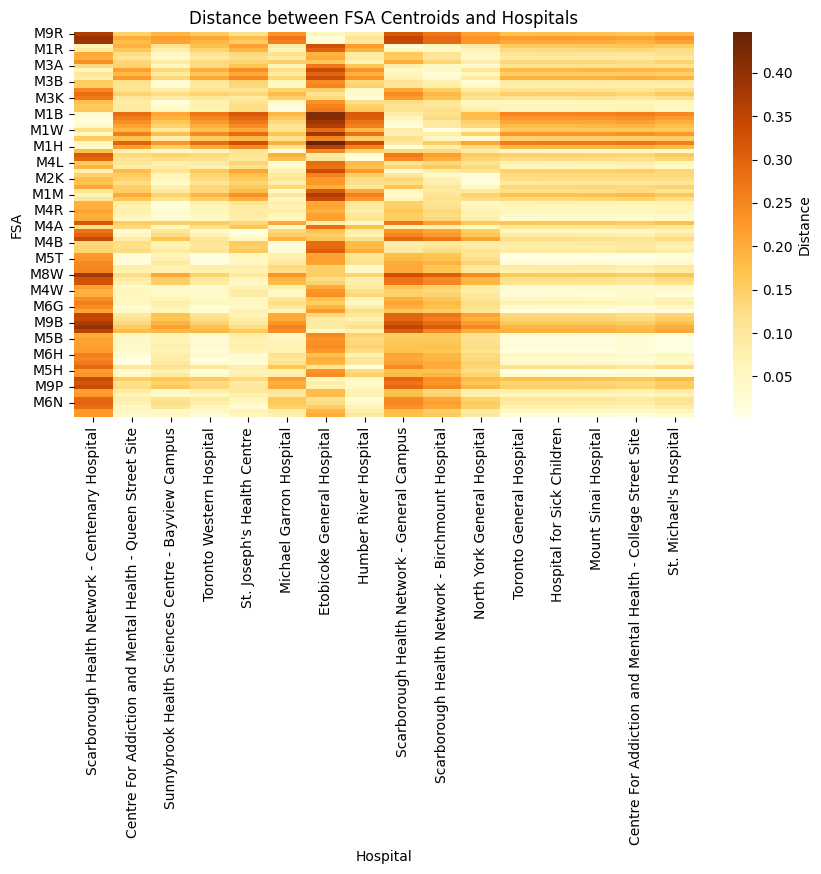

In [ ]:
warnings.filterwarnings('ignore')
import seaborn as sns
### you code here##
#plot the heatmap

plt.figure(figsize=(10, 5))
sns.heatmap(distance_matrix, cmap='YlOrBr', cbar_kws={'label': 'Distance'})
plt.title('Distance between FSA Centroids and Hospitals')
plt.xlabel('Hospital')
plt.ylabel('FSA')
plt.show()

It appears as though FSAs: M1B, M1W, M1H, have the least number of nearby hospitals. It also appears that M5B and M6H are downtown, since they all have close proximity to the downtown hospitals (SickKids, Mount Sinai, CAMH, St. Michaels...)

However, it is difficult to gain more insights since not all FSAs are listed in the plot, and the FSAs themselves are not necessarily ordered by region

## Visualizing Health Network Fairness


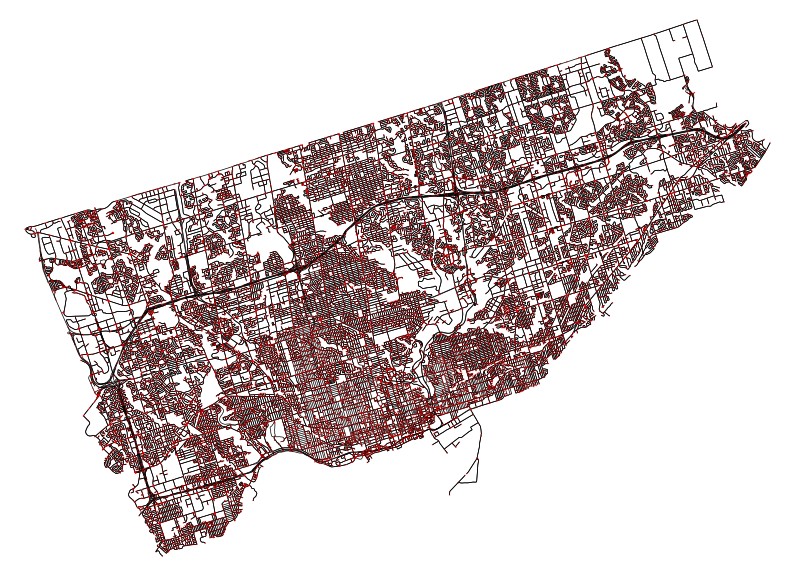

In [ ]:
## you code here ##
place = "City of Toronto, Ontario, Canada" # Identify city
tor_map = ox.graph.graph_from_place(place, network_type='drive') # Get drivable roads

ox.plot_graph(tor_map, figsize=(10, 10), bgcolor='w',node_size=1, node_alpha=0.5, node_color='r',
              edge_linewidth=0.5, edge_color='k') #show edge only
plt.show()

# the solution might take > 1 min to run

In [ ]:
# Total number of nodes
print(f'Total number of nodes: {tor_map.number_of_nodes()}')
# Total number of edges
print(f'Total number of edges: {tor_map.number_of_edges()}')

Total number of nodes: 27390
Total number of edges: 73051


In [ ]:
### DO NOT MODIFY ###
warnings.filterwarnings('ignore')
distance_matrix_by_shortest_path = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/distance_matrix_by_shortest_path.csv', index_col=0)
# create a new pandas series to store the nearest distance
smallest_distance_by_shortest_path = distance_matrix_by_shortest_path.min(axis=1)
# assign the name of the series for future merging
smallest_distance_by_shortest_path.name = 'nearest_hospital'

# obtain all row that is a foward sortation area
toronto_FSA.to_crs(epsg=4326, inplace=True)
toronto_FSA['centroid'] = toronto_FSA['geometry'].apply(lambda x: x.centroid)
# merge the distance series with the FSA shape data
gdf_smallest_distance_by_shortest_path = toronto_FSA.merge(smallest_distance_by_shortest_path, left_on='name', right_index=True).rename(columns={0: 'nearest_hospital'})
gdf_smallest_distance_by_shortest_path.head()
# Since the given code reuse some code in previous questions, which can be accidentally manipulated in some cases.
# To make sure the given code generates the correct value for your assignment, we want you to run the given code and validate the output matches with our original output.
# your output should be exactly the same as the expected output, if not, re-run given code in Q1

,name,geometry,property_type,centroid,nearest_hospital
637,M9R,"POLYGON ((-79.56131 43.67478, -79.56249 43.674...",FSA,POINT (-79.55799 43.68778),6973.215
638,M9V,"POLYGON ((-79.57759 43.76205, -79.57829 43.761...",FSA,POINT (-79.59433 43.74274),1854.019
639,M9W,"POLYGON ((-79.53885 43.72937, -79.53884 43.728...",FSA,POINT (-79.58416 43.70983),2981.682
701,M1P,"POLYGON ((-79.24704 43.75374, -79.2472 43.7536...",FSA,POINT (-79.27 43.76213),2710.604
702,M1R,"MULTIPOLYGON (((-79.28125 43.73867, -79.27985 ...",FSA,POINT (-79.29717 43.74945),4471.884


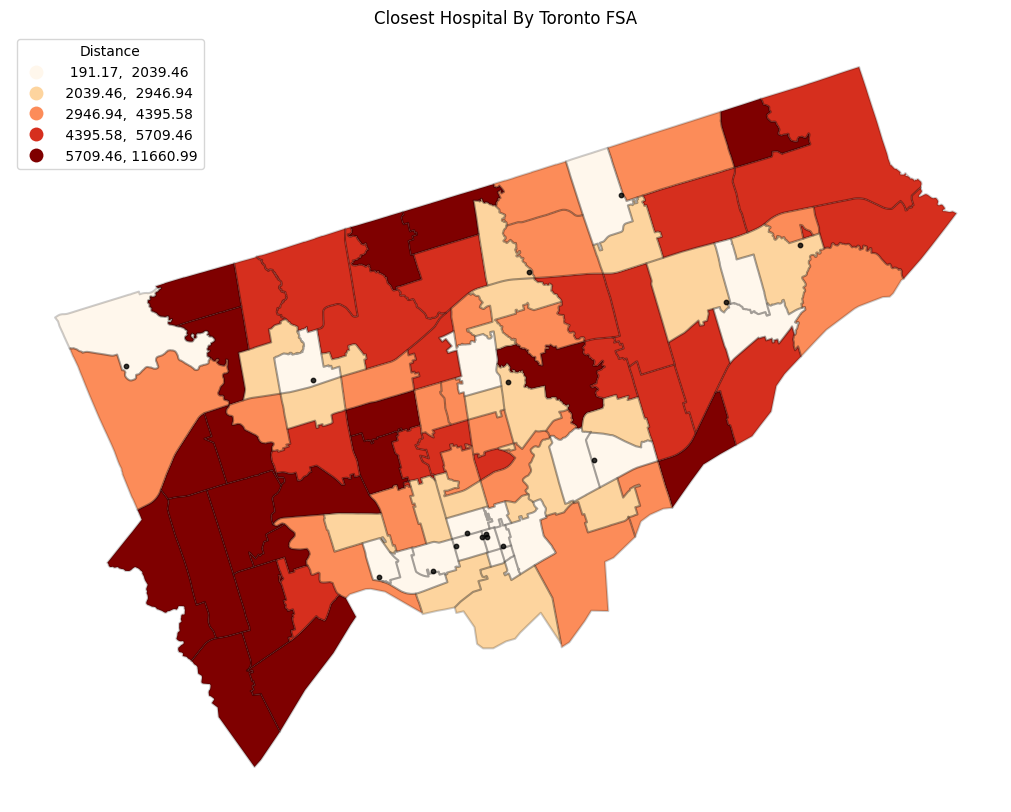

In [ ]:
## you code here ##

fig, ax = plt.subplots(figsize=(20, 10))

# obtain all row that is a foward sortation area
gdf_FSA = gdf_smallest_distance_by_shortest_path[gdf_smallest_distance_by_shortest_path['property_type'] == 'FSA']
# merge the distance series with the FSA shape data

gdf_smallest_distance_by_shortest_path.plot(column='nearest_hospital',
                                            legend=True,
                                            legend_kwds={'loc': 'upper left', 'title': 'Distance'},
                                            scheme='quantiles',
                                            cmap='OrRd',
                                            figsize=(10, 10),
                                            ax=ax)
gdf_smallest_distance_by_shortest_path.boundary.plot(figsize=(10, 10), color = 'black',alpha=0.2,ax = ax)


# add hospitals
gdf_all[gdf_all['property_type'] == 'hospital'].plot(ax = ax, color='black', alpha=0.8, markersize=10)
ax.set_title('Closest Hospital By Toronto FSA')
ax.axis('off')

plt.show()


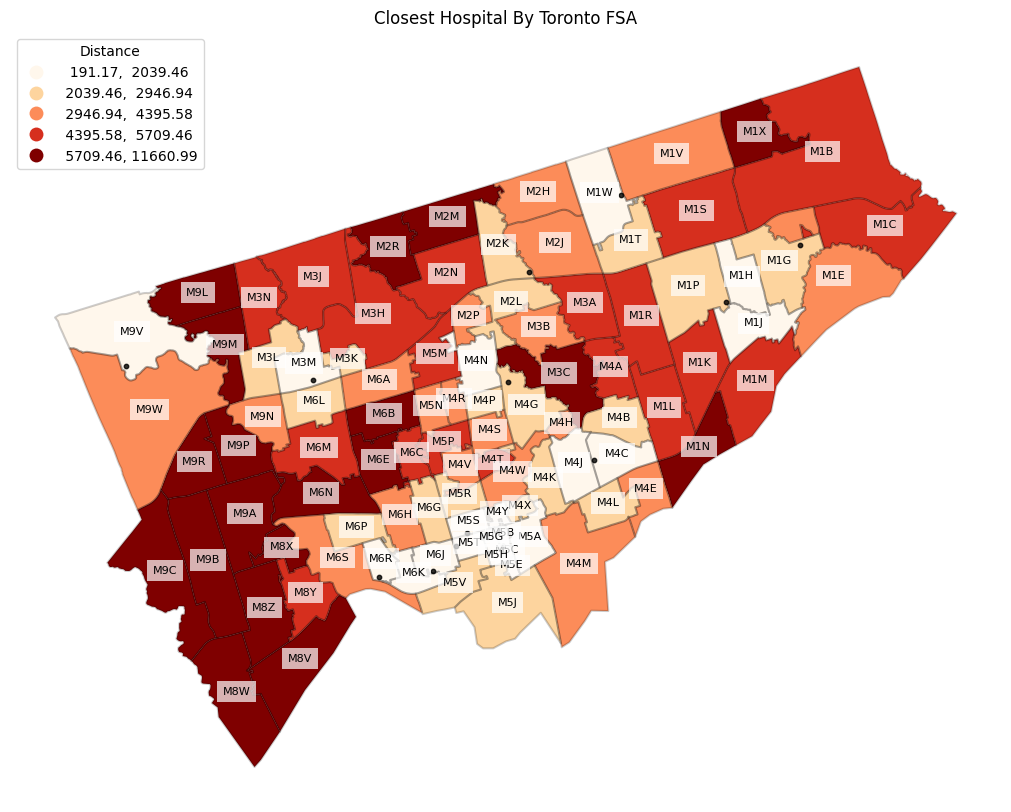

In [ ]:
# Adding a version with FSA labels:
fig, ax = plt.subplots(figsize=(20, 10))

# obtain all row that is a foward sortation area
gdf_FSA = gdf_smallest_distance_by_shortest_path[gdf_smallest_distance_by_shortest_path['property_type'] == 'FSA']
# merge the distance series with the FSA shape data

gdf_smallest_distance_by_shortest_path.plot(column='nearest_hospital',
                                            legend=True,
                                            legend_kwds={'loc': 'upper left', 'title': 'Distance'},
                                            scheme='quantiles',
                                            cmap='OrRd',
                                            figsize=(10, 10),
                                            ax=ax)
gdf_smallest_distance_by_shortest_path.boundary.plot(figsize=(10, 10), color = 'black',alpha=0.2,ax = ax)

for idx, row in gdf_FSA.iterrows():
  if row['property_type'] == 'FSA':
    centroid = row['geometry'].centroid  # Compute centroid
    ax.text(centroid.x, centroid.y, row['name'], fontsize=8, ha='center', color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))  # White background for readability


# add hospitals
gdf_all[gdf_all['property_type'] == 'hospital'].plot(ax = ax, color='black', alpha=0.8, markersize=10)
ax.set_title('Closest Hospital By Toronto FSA')
ax.axis('off')

plt.show()

The West-end of Toronto (Etobicoke) is the region where hospitals are the furthest. By contrast, downtown regions are closest to hospitals, and downtown does have many hospitals

In [ ]:
## DO NOT MODIFY ##
warnings.filterwarnings('ignore')
census_data = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/2016_census.csv').iloc[:, 1:]
census_data.columns = ['name', 'median_income', 'population','visual_minority']
census_data['prec_visual_minority'] = census_data['visual_minority'] / census_data['population']
census_data = toronto_FSA.merge(census_data, on='name')
census_data = census_data[['name','prec_visual_minority','centroid']]
census_data.head()



,name,prec_visual_minority,centroid
0,M9R,0.544557,POINT (-79.55799 43.68778)
1,M9V,0.814882,POINT (-79.59433 43.74274)
2,M9W,0.689214,POINT (-79.58416 43.70983)
3,M1P,0.737640,POINT (-79.27 43.76213)
4,M1R,0.564003,POINT (-79.29717 43.74945)


In [ ]:
# empty folium map
nearest_hospital_map = fm.Map(location=[43.7, -79.4], zoom_start=12,
                                  scrollWheelZoom=False, tiles=None,
                                    control_scale=True)
# geo-json file with vector shape of FSA
FSA_json = gdf_smallest_distance_by_shortest_path[['name', 'geometry']].to_json()

## you code here ##

# Add tile layer
fm.TileLayer('openstreetmap').add_to(nearest_hospital_map)

# Add choropleth layer
quantiles = gdf_smallest_distance_by_shortest_path['nearest_hospital'].quantile([0, 0.25, 0.5, 0.75, 1]).to_list()

fm.Choropleth(
    geo_data=FSA_json,
    name='Distance to Nearest Hospital',
    data=gdf_smallest_distance_by_shortest_path,
    columns=['name', 'nearest_hospital'],
    key_on='feature.properties.name',
    fill_color='OrRd', # color for the choropleth
    fill_opacity=0.4, # opacity of the fill color
    line_opacity=0.2, # opacity of the boundary line
    bins = quantiles, # bins to classify the data
    legend_name='Distance to the Nearest Hospital' # name of the legend
    ).add_to(nearest_hospital_map)

# Add circle marker layer (Doing one to plot hospitals)
hospital = fm.FeatureGroup(name="Hospital", control=True).add_to(nearest_hospital_map) #feature group will make all the layer in this group can be controlled as a single layer

for i, row in hospital_centroid.iterrows():
    fm.Marker([row['centroid'].y, row['centroid'].x], # define the location of the marker
              popup=row['name'], # define the popup message
              icon=fm.Icon(color='black', icon='hospital', prefix='fa') # define the icon of the marker
             ).add_to(hospital) # add the marker to the feature group


# Adding circle markers for minority rate
minority_rate = fm.FeatureGroup(name="Median Income", control=True).add_to(nearest_hospital_map)

for index, row in census_data.iterrows():
    centroid = [row['centroid'].y, row['centroid'].x]
    fm.CircleMarker(centroid, radius=row['prec_visual_minority']*20, color='blue',
     fill=True, fill_color='blue').add_to(minority_rate)



# Adding layer control feature
fm.TileLayer('cartodb dark_matter',show=False).add_to(nearest_hospital_map) # add the dark matter tile layer, show=False means the layer is not shown by default
fm.TileLayer('cartodb positron',show=False).add_to(nearest_hospital_map) # add the positron tile layer

fm.LayerControl().add_to(nearest_hospital_map) # add the layer control

nearest_hospital_map



Visually, there seems to be a trend between driving proximity to hospitals and pressence of visual minorities. For example, the region in the North-East part of Toronto has a very large proportion of minorities, and has very long distances to the nearest hospital. Regions closer to downtown have fewer minorities, and have relatively small distances to the nearest hospital.